# **Chapter 7**
## *Handling Missing Data*, 

This chapter explores different methods for identifying and handling missing data. You will learn different imputation and interpolation techniques. The chapter starts with simple statistical methods for univariate imputation and then explores various univariate interpolation algorithms for more advanced multivariate imputation.

In this chapter, you will explore techniques to handle missing data through **imputation** and **interpolation**.  

Here is the list of recipes that we will cover in this chapter:
* Performing data quality checks
* Handling missing data with univariate imputation using pandas
* Handling missing data with univariate imputation using scikit-learn
* Handling missing data with multivariate imputation
* Handling missing data with interpolation

# Technical Requirements
* In this chapter, two datasets will be used extensively for the imputation and interpolation recipes: 
    * the CO2 Emissions dataset, and the e-Shop Clickstream dataset. The source for the Clickstream dataset comes from clickstream data for online shopping from the UCI machine learning repository, which you can find here: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
    * The source for the CO2 emissions dataset comes from the Annual CO2 emissions report from Our World in Data, which you can find here: https://ourworldindata.org/ co2-emissions.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

In this chapter and beyond, you will extensively use pandas 1.4.2 (released April 2, 2022). There will be four additional libraries that you will be using:

* NumPy (≥ 1.20.3)
* Matplotlib (≥ 3.5.0)
* statsmodels (≥ 0.11.0)
* scikit-learn (≥ 1.0.1)
* SciPy (≥ 1.7.1)


* If you are using pip, then you can install these packages from your terminal with the following command:

```
pip install matplotlib numpy statsmodels scikit-learn scipy
```

* If you are using conda, then you can install these packages with the following command:

```
conda install matplotlib numpy statsmodels scikit-learn scipy
```

In [2]:
import matplotlib
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')


pandas -> 1.5.0
numpy -> 1.23.3
matplotlob -> 3.6.0
statsmodels -> 0.13.2
scikit-learn -> 1.1.2



## Preparing for the recipes of this chapter

## Functions used
* Create all necessary functions that will be used
### `read_datesets()`

In [46]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(os.path.join(folder, file),
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df


### `plot_dfs()`

In [4]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()


### `rmse_score()`

In [5]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


# Recipe 1: Perform Data Quality Checks
* Examples of missing data
* Understand `NaN` vs `NaT`
* Identify missing observations that are replaced with other values in the source system but should be considered as missing
* Explain `na_values` and `keep_default_na` parameters 

In [6]:
co2 = os.path.join('..', '..', 'Time-Series-Analysis-with-Python-Cookbook-main',
                   'datasets', 'Ch7', 'co2_missing.csv')
ecom = os.path.join('..', '..', 'Time-Series-Analysis-with-Python-Cookbook-main',
                    'datasets', 'Ch7', 'clicks_missing_multiple.csv')

co2_df = pd.read_csv(co2)
ecom_df = pd.read_csv(ecom, parse_dates=['date'])

In [7]:
print(co2_df.info())
print(co2_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    226 non-null    int64  
 1   co2     201 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.7 KB
None
(226, 2)


In [8]:
print(ecom_df.info())
print(ecom_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB
None
(135, 4)


In [9]:
ecom_df.head()

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784
1,2008-04-02,43.079056,1.0,24738
2,NaT,43.842609,NaN,15209
3,NaT,NaN,1.0,14018
4,NaT,43.941176,1.0,11974


In [10]:
co2_df.head()

,year,co2
0,1750,0.0125
1,1760,0.0128
2,1770,0.0150
3,1780,0.0169
4,1790,0.0206


In [11]:
co2_df.isnull().sum()

year     0
co2     25
dtype: int64

In [12]:
# using isna()
co2_df.isna().sum()

year     0
co2     25
dtype: int64

In [13]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [14]:
# using isnull()
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [15]:
# using isnull()
ecom_df.isnull().sum().sum()

20

In [16]:
co2_df[190:195]

,year,co2
190,1985,NaN
191,1986,NaN
192,1987,NaN
193,1988,4.2953
194,1989,4.2782


In [17]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [18]:
ecom_df.isnull().values.any()

True

In [19]:
co2_df.isnull().values.any()

True

In [20]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [21]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    226 non-null    int64  
 1   co2     201 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.7 KB


In [22]:
co2_df.describe(include='all', 
                datetime_is_numeric=True)

,year,co2
count,226.000000,201.000000
mean,1906.902655,1.590015
std,66.543281,1.644182
min,1750.000000,0.000000
25%,1851.250000,0.076400
50%,1907.500000,0.935100
75%,1963.750000,2.807600
max,2020.000000,4.907900


In [23]:
ecom_df.describe(include='all', 
                 datetime_is_numeric=True)

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [24]:
test = pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})

In [25]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [26]:
co2_df.replace(0, np.NaN, inplace=True)
ecom_df.replace('?', np.NaN, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

In [27]:
co2_df.isnull().sum()

year     0
co2     35
dtype: int64

In [28]:
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## How it works

In [29]:
co2_df = pd.read_csv(co2, keep_default_na=False)

In [30]:
co2_df.iloc[132:139]

,year,co2
132,1927,
133,1928,
134,1929,
135,1930,
136,1931,
137,1932,
138,1933,


In [31]:
co2_df.iloc[132:139]['co2'] == ''

132    True
133    True
134    True
135    True
136    True
137    True
138    True
Name: co2, dtype: bool

In [32]:
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [33]:
co2_df.shape

(226, 2)

In [34]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [35]:
co2_df[190:195]

,year,co2
190,1985,NA
191,1986,N/A
192,1987,null
193,1988,4.2953
194,1989,4.2782


In [36]:
co2_df.isnull().sum()
co2_df.isnull().sum().sum()

0

### There is More

In [37]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [38]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).isna().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

# Recipe 2: Handling Missing Data with Univariate Imputation using pandas  

Some basic univariate imputation techniques include the following:
* Imputing using the mean.
* Imputing using the last observation forward (forward fill). This can be referred to as Last Observation Carried Forward (LOCF).
* Imputing using the next observation backward (backward fill). This can be referred to as Next Observation Carried Backward (NOCB).  

You will use two datasets to impute missing data using different techniques and then compare the results.

In [44]:
import pandas as pd
from os.path import join as os_path_join
import matplotlib.pyplot as plt

In [49]:
folder = os_path_join('..', '..', 'Time-Series-Analysis-with-Python-Cookbook-main',
                    'datasets', 'Ch7')

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')


In [50]:
co2_missing.isnull().sum()

co2    35
dtype: int64

In [51]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [52]:
clicks_missing.loc[:, 'missing':].shape[1]

2

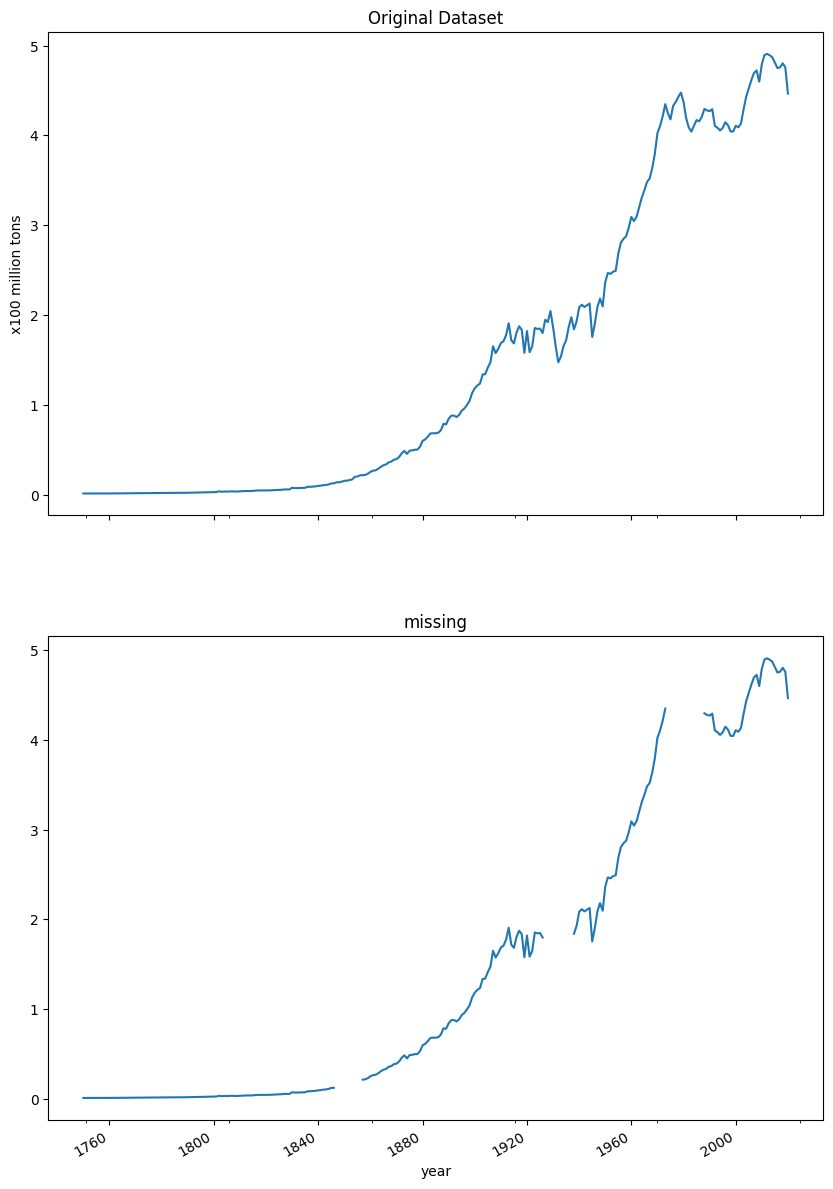

In [53]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

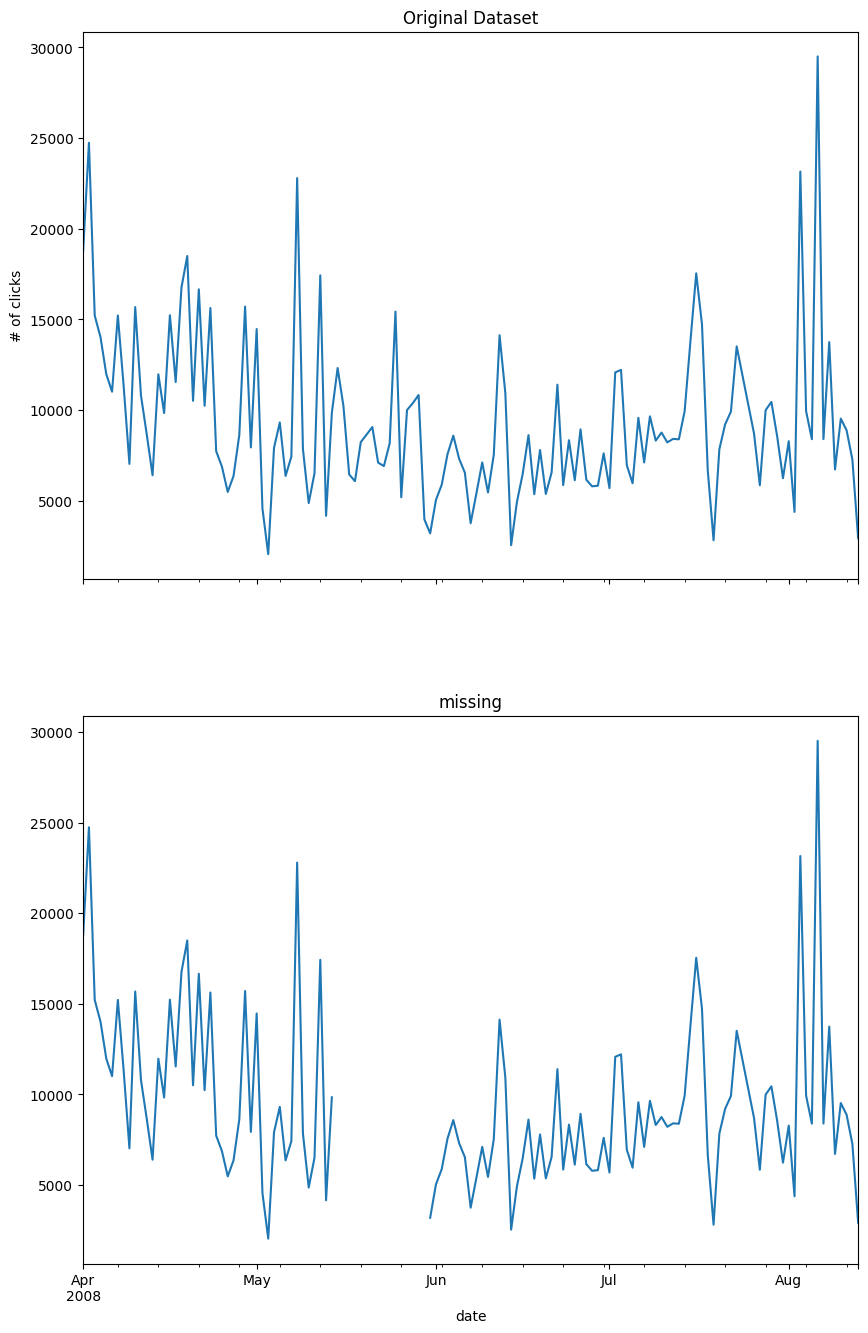

In [54]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

In [55]:
co2_missing['ffill'] = co2_missing['co2'].fillna(method='ffill')
co2_missing['bfill'] = co2_missing['co2'].fillna(method='bfill')
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

In [56]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


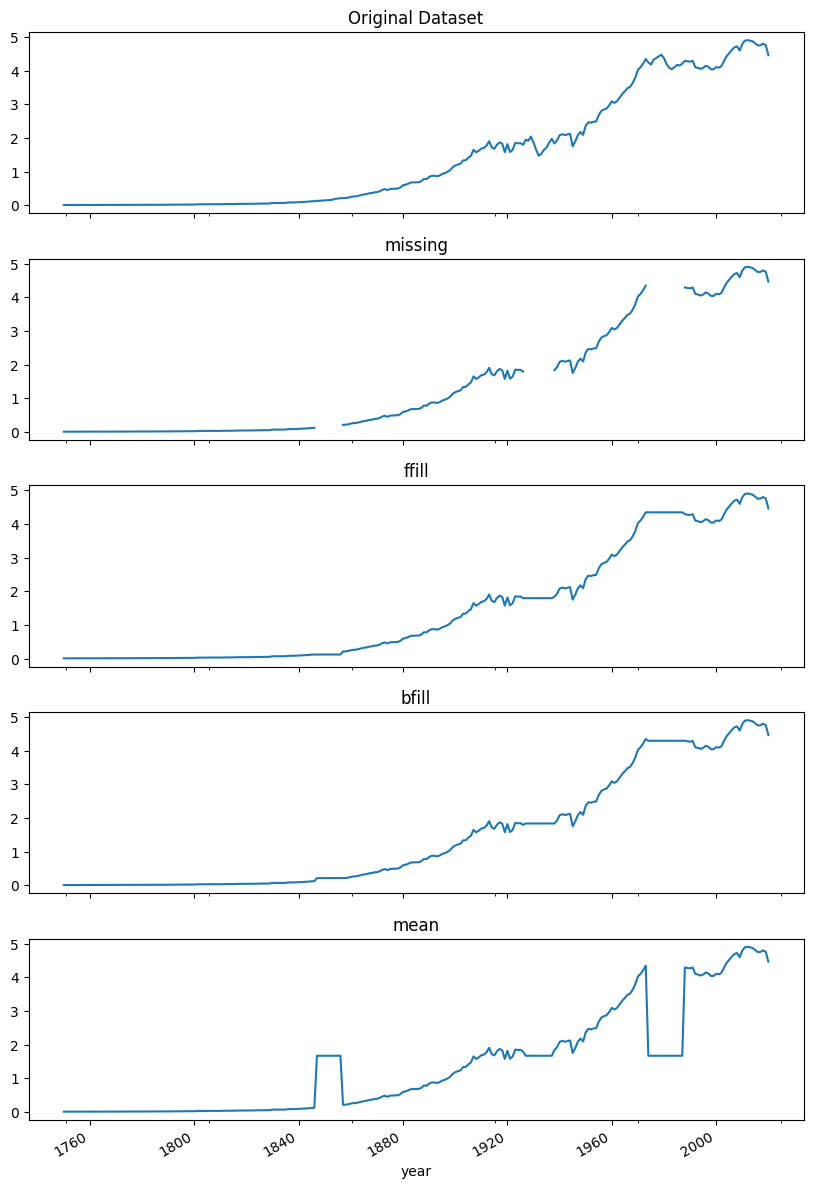

In [57]:
plot_dfs(co2_original, co2_missing, 'co2')

In [58]:
clicks_missing['ffil'] = clicks_missing['clicks'].fillna(method='ffill')
clicks_missing['bfill'] = clicks_missing['clicks'].fillna(method='bfill')
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [59]:
_ = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


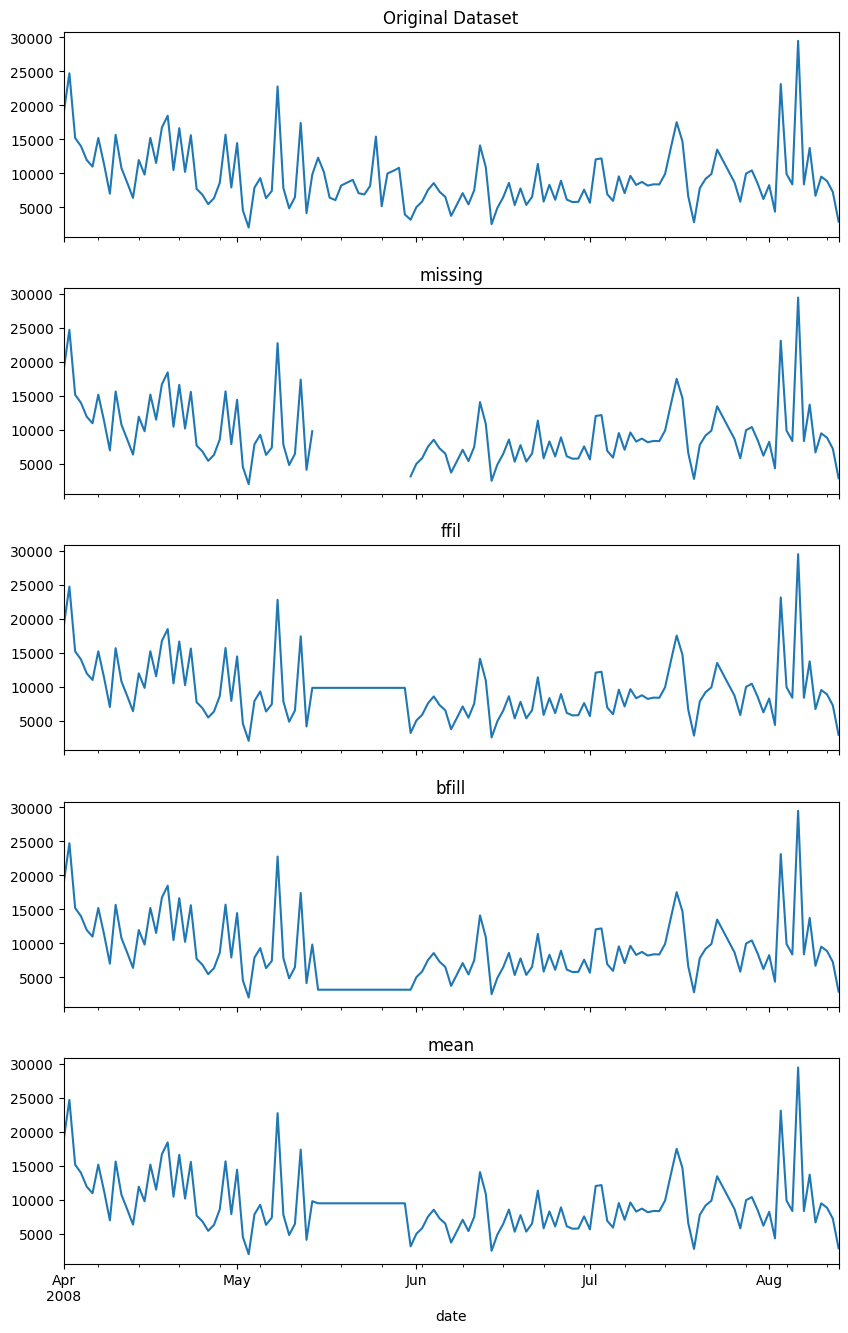

In [60]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [61]:
clicks_missing.loc['2008-05-10':'2008-05-18']

,price,location,clicks,ffil,bfill,mean
date,,,,,,
2008-05-10,42.576299,1,4863.0,4863.0,4863.0,4863.000000
2008-05-11,43.405890,5,6511.0,6511.0,6511.0,6511.000000
2008-05-12,43.258326,2,17426.0,17426.0,17426.0,17426.000000
2008-05-13,42.714479,2,4160.0,4160.0,4160.0,4160.000000
2008-05-14,43.372786,5,9841.0,9841.0,9841.0,9841.000000
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134


In [62]:
clicks_missing.loc['2008-05-30':'2008-06-15']

,price,location,clicks,ffil,bfill,mean
date,,,,,,
2008-05-30,44.558011,5,NaN,9841.0,3194.0,9530.336134
2008-05-31,43.100427,2,3194.0,3194.0,3194.0,3194.000000
2008-06-01,42.875000,2,5038.0,5038.0,5038.0,5038.000000
2008-06-02,43.406951,2,5879.0,5879.0,5879.0,5879.000000
2008-06-03,42.957505,5,7563.0,7563.0,7563.0,7563.000000
2008-06-04,42.930399,2,8584.0,8584.0,8584.0,8584.000000
2008-06-05,42.801887,2,7315.0,7315.0,7315.0,7315.000000
2008-06-06,43.740476,2,6541.0,6541.0,6541.0,6541.000000
2008-06-07,43.823729,1,3755.0,3755.0,3755.0,3755.000000


In [63]:
clicks_missing[clicks_missing['clicks'].isna()]

,price,location,clicks,ffil,bfill,mean
date,,,,,,
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134
2008-05-19,43.892996,2,NaN,9841.0,3194.0,9530.336134
2008-05-20,43.247706,2,NaN,9841.0,3194.0,9530.336134
2008-05-21,44.106289,1,NaN,9841.0,3194.0,9530.336134
2008-05-22,43.810714,1,NaN,9841.0,3194.0,9530.336134
2008-05-23,43.620802,1,NaN,9841.0,3194.0,9530.336134


### There is More

In [64]:
co2_missing['co2'].ffill()
co2_missing['co2'].bfill()
clicks_missing['clicks'].ffill()
clicks_missing['clicks'].bfill()

date
2008-04-01    18784.0
2008-04-02    24738.0
2008-04-03    15209.0
2008-04-04    14018.0
2008-04-05    11974.0
               ...   
2008-08-09     6716.0
2008-08-10     9523.0
2008-08-11     8881.0
2008-08-12     7272.0
2008-08-13     2922.0
Name: clicks, Length: 135, dtype: float64

# Recipe 3: Handling Missing Data with Univariate Imputation using Scikit-Learn
* Using Sckit-Learn `SimpleImputer`

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from os.path import join as os_path_join

In [ ]:
folder = os_path_join('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [ ]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]

In [ ]:
co2_vals = co2_missing['co2'].values.reshape(-1,1)
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)

for s_name, s in strategy:
    co2_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(co2_vals))
    clicks_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(clicks_vals))

In [ ]:
_ = rmse_score(co2_original, co2_missing, 'co2')

In [ ]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

In [ ]:
plot_dfs(co2_original, co2_missing, 'co2')

In [ ]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## There is more

In [ ]:
avg = co2_missing['co2'].mean()
co2_missing['pands_fillna'] = co2_missing['co2'].fillna(avg)

In [ ]:
co2_missing

In [ ]:
cols = ['co2', 'Mean Strategy', 'pands_fillna']
_ = rmse_score(co2_original, co2_missing[cols], 'co2')

# Recipe 4: Handling Missing Data with Multivariate Imputation
* In this recipe, you will be working with the Clickstream dataset since it has additional variables (clicks, price, and location columns) to perform multivariate imputation for clicks.
* Using Scikit-Learn `IterativeImputer`
* Using statsmodels `MICE` implementation

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
folder = Path('../../datasets/Ch7/')

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date')

In [ ]:
clicks_missing.isna().sum()

In [ ]:
estimators = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]


In [ ]:
clicks_vals = clicks_missing.iloc[:,0:3].values

for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]

    
    

In [ ]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

In [ ]:

plot_dfs(clicks_original, clicks_missing, 'clicks')

### There is more

In [ ]:
from statsmodels.imputation.mice import MICE, MICEData, MICEResults
import statsmodels.api as sm

In [ ]:
# create a MICEData object
fltr = ['price', 'location','clicks']
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
# 20 iterations
mice_data.update_all(n_iter=20)

mice_data.set_imputer('clicks', formula='~ price + location', model_class=sm.OLS)

In [ ]:
clicks_missing['MICE']  = mice_data.data['clicks'].values.tolist()

In [ ]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

In [ ]:
cols = ['clicks','bayesianRidge', 'bagging', 'knn', 'MICE']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

In [ ]:
_ = mice_data.plot_imputed_hist('clicks')

In [ ]:
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
mice_data.update_all(n_iter=20)
_ = mice_data.plot_fit_obs('clicks')

# Recipe 4: Handling Missing Data with Interpolation
* In this recipe, you will use the`.interpolate()` function to examine different interpolation methods, including `linear`, `polynomial`, `quadratic`, `nearest`, and `spline`.

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [ ]:
co2_missing.interpolate()

In [ ]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)


co2_missing['spline'] = \
        co2_missing['co2'].interpolate(method='spline', order=3)
clicks_missing['spline'] = \
        clicks_missing['clicks'].interpolate(method='spline',order=3)

co2_missing['polynomial'] = \
        co2_missing['co2'].interpolate(method='polynomial',order=3)
clicks_missing['polynomial'] = \
        clicks_missing['clicks'].interpolate(method='polynomial',order=3)



In [ ]:
_ = rmse_score(co2_original, co2_missing, 'co2')

In [ ]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

In [ ]:
cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic']
plot_dfs(co2_original, co2_missing[cols], 'co2')

In [ ]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

### How it works

In [ ]:
clicks_missing['clicks'].isna().sum()

In [ ]:
example = clicks_missing['clicks'].interpolate(limit = 5)

In [ ]:
example.isna().sum()

In [ ]:
clicks_missing['clicks']['2008-05-14':]

In [ ]:
example['2008-05-14':]

### There is more

In [ ]:
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [ ]:
clicks_missing.head()

In [ ]:
clicks_missing['clicks']['2008-05-14':]

In [ ]:
clicks_missing.shape